# eDisGo basic emobility example

This example shows you the first steps how to integrate electromobility into eDisGo.

### Learn more about eDisGo

* __[eDisGo Source Code](https://github.com/openego/eDisGo)__
* __[eDisGo Documentation](http://edisgo.readthedocs.io/en/dev/)__

### Table of Contents


* [Installation](#installation)
* [Settings](#settings)
* [eDisGo add electromobility](#emob)
* [eDisGo electromobility data structure](#network)

## Installation <a class="anchor" id="installation"></a>

This notebook requires a working installation of eDisGo as well as `jupyter notebook` to run the example and `contextily` to view the grid topology on a map. You can install all of these as follows:

```python
pip install -e .[full]
```

Checkout the eDisGo documentation on [how to install eDisGo](https://edisgo.readthedocs.io/en/dev/quickstart.html#getting-started) for more information.

#### Import packages

In [1]:
import edisgo as ed
import geopandas as gpd
import pandas as pd
import requests
import zipfile

import matplotlib.pyplot as plt

from copy import deepcopy
from pathlib import Path

from edisgo.edisgo import EDisGo

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/sqlalchemy/ext/declarative/base.py:433: SAWarning:

Ignoring declarative-like tuple value of attribute 'segment': possibly a copy-and-paste error with a comma accidentally placed at the end of the line?

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/sqlalchemy/ext/declarative/base.py:433: SAWarning:

Ignoring declarative-like tuple value of attribute 'cable': possibly a copy-and-paste error with a comma accidentally placed at the end of the line?



## Settings <a class="anchor" id="settings"></a>

The class **EDisGo** serves as the top-level API for
setting up your scenario, invocation of data import, power flow analysis, grid reinforcement and flexibility measures. It also provides access to all relevant data. See the [class documentation](http://edisgo.readthedocs.io/en/dev/api/edisgo.grid.html#edisgo.grid.network.EDisGo) for more information.

To set up a scenario to do a worst-case analysis that considers the heavy load flow and reverse power flow cases used in distribution grid planning, you simply have to provide a grid and call the function`set_time_series_worst_case_analysis`, which is both explained in the following two sections. 

### Distribution grid data

Currently, synthetic grid data generated with the python project
[ding0](https://github.com/openego/ding0)
is the only supported data source for distribution grid data. ding0 provides the grid topology data in the form of csv files, with separate files for buses, lines, loads, generators, etc. You can retrieve ding0 data from
[Zenodo](https://zenodo.org/record/890479)
(make sure you choose latest data) or check out the
[Ding0 documentation](https://dingo.readthedocs.io/en/dev/usage_details.html#ding0-examples)
on how to generate grids yourself. A ding0 example grid can be viewed [here](https://github.com/openego/eDisGo/tree/dev/tests/data/ding0_test_network_2). It is possible to provide your own grid data if it is in the same format as the ding0 grid data.

Time series for fluctuating generators and conventional loads are imported from [OEDB](https://openenergy-platform.org/dataedit/schemas) and [demandlib](https://github.com/oemof/demandlib). To integrate electromobility generated by [SimBEV](https://github.com/rl-institut/simbev) the time series needs to be resampled to 15 minutes basis.

In [2]:
# define path to ding0 network
data_dir = Path(ed.__file__).resolve().parent.parent / "tests/data"
ding0_grid = data_dir / "ding0_test_network_4"

In [3]:
edisgo = EDisGo(ding0_grid=ding0_grid)

timeindex = pd.date_range("1/1/2011", periods=24 * 7, freq="H")

edisgo.set_timeindex(timeindex)

edisgo.set_time_series_active_power_predefined(
    fluctuating_generators_ts="oedb",
    dispatchable_generators_ts=pd.DataFrame(data=1, columns=["other"], index=timeindex),
    conventional_loads_ts="demandlib",
)

edisgo.set_time_series_reactive_power_control()

edisgo.resample_timeseries()

edisgo.timeseries.generators_active_power.head()

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 19, 3], imported network file PyPSA version None.

INFO:pypsa.io:Imported network ding0_test_network_4 has buses, generators, lines, loads, transformers
/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning:

Iteration over multi-part geometries is de

,Generator_mvgd_2095_lvgd_131066_solar_roof_mounted_1217753,Generator_mvgd_2095_lvgd_131066_solar_roof_mounted_1218150,Generator_mvgd_2095_lvgd_131066_solar_roof_mounted_1218180,Generator_mvgd_2095_lvgd_131066_solar_roof_mounted_1218181,Generator_mvgd_2095_lvgd_131067_solar_roof_mounted_1218110,Generator_mvgd_2095_lvgd_131067_solar_roof_mounted_1218134,Generator_mvgd_2095_lvgd_131067_solar_roof_mounted_1218137,Generator_mvgd_2095_lvgd_131067_solar_roof_mounted_1218139,Generator_mvgd_2095_lvgd_131068_solar_roof_mounted_1218185,Generator_mvgd_2095_lvgd_131069_solar_roof_mounted_1218147,...,Generator_mvgd_2095_lvgd_136383_solar_roof_mounted_1218140,Generator_mvgd_2095_lvgd_136383_solar_roof_mounted_1218194,Generator_mvgd_2095_lvgd_136383_solar_roof_mounted_1218195,Generator_mvgd_2095_lvgd_515413_solar_roof_mounted_1217920,Generator_mvgd_2095_lvgd_515413_solar_roof_mounted_1218048,Generator_mvgd_2095_lvgd_515413_solar_roof_mounted_1218080,Generator_mvgd_2095_lvgd_515413_solar_roof_mounted_1218135,Generator_mvgd_2095_lvgd_515413_solar_roof_mounted_1218151,Generator_mvgd_2095_lvgd_515413_solar_roof_mounted_1218183,Generator_mvgd_2095_lvgd_515414_solar_roof_mounted_1218079
2011-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


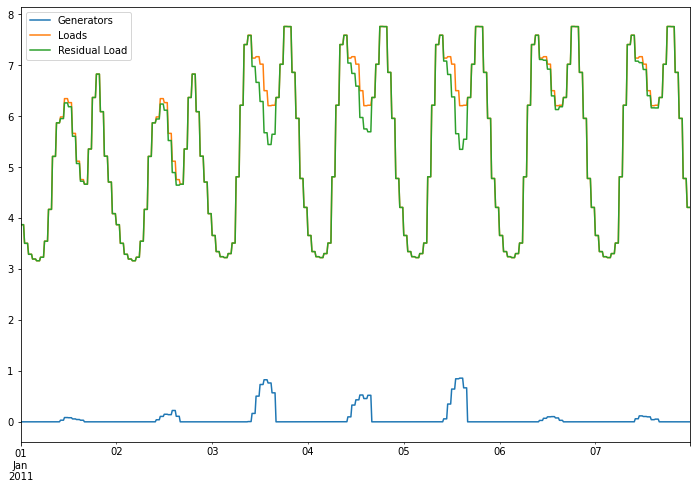

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))

edisgo.timeseries.generators_active_power.sum(axis=1).plot.line(ax=ax)
edisgo.timeseries.loads_active_power.sum(axis=1).plot.line(ax=ax)
edisgo.timeseries.residual_load.plot.line(ax=ax)

ax.legend(["Generators", "Loads", "Residual Load"])

plt.show()

## Preparation of the mobility data

Currently, only for [SimBEV](https://github.com/rl-institut/simbev) and [TracBEV](https://github.com/rl-institut/tracbev) there is an automated process in eDisGo for processing the tool data.

### Download 'Verwaltungsgebiet' data

Since [SimBEV](https://github.com/rl-institut/simbev) and [TracBEV](https://github.com/rl-institut/tracbev) generate data on a municipality-by-municipality basis, it is necessary to determine which municipalities lie within or intersect the network area. Therefore municipality geodata is necessary.

In [5]:
vg250_path = Path.home() / ".edisgo" / "vg250"

target = vg250_path / "vg250_01-01.geo84.shape.ebenen/vg250_ebenen_0101/VG250_GEM.shp"

if not target.is_file():
    vg250_path.mkdir(parents=True, exist_ok=True)

    # Writing the file to the local file system
    filename = vg250_path / "vg250.geo84"

    url = "https://daten.gdz.bkg.bund.de/produkte/vg/vg250_ebenen_0101/2020/vg250_01-01.geo84.shape.ebenen.zip"
    req = requests.get(url)

    with open(filename, "wb") as fout:
        fout.write(req.content)

    with zipfile.ZipFile(vg250_path / "vg250.geo84", "r") as zip_ref:
        zip_ref.extractall(vg250_path)

vg250 = gpd.read_file(target)

vg250.head()

,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,IBZ,BEM,...,FK_S3,NUTS,ARS_0,AGS_0,WSK,DEBKG_ID,RS,SDV_RS,RS_0,geometry
0,6,4,1,010010000000,01001000,010010000000,Flensburg,Stadt,60,kreisfrei,...,R,DEF01,010010000000,01001000,2008-01-01,DEBKGDL20000E5MA,010010000000,010010000000,010010000000,"POLYGON ((9.41266 54.82264, 9.41318 54.82124, ..."
1,6,4,1,010020000000,01002000,010020000000,Kiel,Stadt,60,kreisfrei,...,R,DEF02,010020000000,01002000,2006-01-01,DEBKGDL20000004J,010020000000,010020000000,010020000000,"POLYGON ((10.16916 54.43138, 10.16957 54.43067..."
2,6,4,1,010030000000,01003000,010030000000,Lübeck,Stadt,60,kreisfrei,...,R,DEF03,010030000000,01003000,2006-02-01,DEBKGDL20000DYMA,010030000000,010030000000,010030000000,"POLYGON ((10.87684 53.98737, 10.87884 53.98595..."
3,6,4,1,010040000000,01004000,010040000000,Neumünster,Stadt,60,kreisfrei,...,R,DEF04,010040000000,01004000,1970-04-26,DEBKGDL20000E4SA,010040000000,010040000000,010040000000,"POLYGON ((9.99545 54.14972, 9.99713 54.14806, ..."
4,6,4,1,010510011011,01051011,010510011011,Brunsbüttel,Stadt,61,--,...,R,DEF05,010510011011,01051011,2009-01-01,DEBKGDL20000E2IK,010510011011,010510011011,010510011011,"POLYGON ((9.16439 53.94509, 9.16706 53.94302, ..."


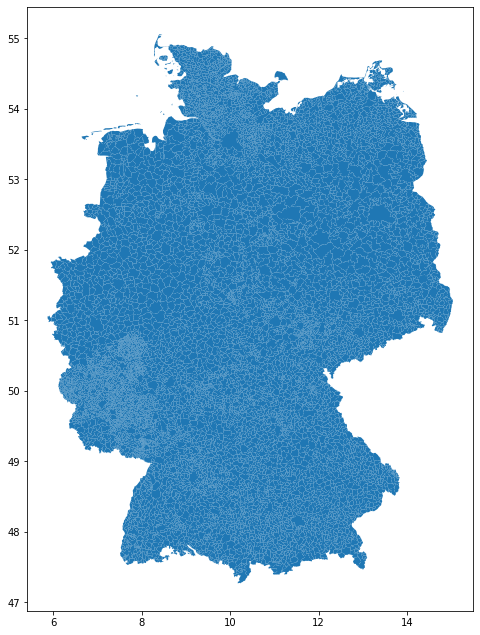

In [6]:
fig, ax = plt.subplots(figsize=(8, 15))

vg250.plot(ax=ax)

plt.show()

### Check which 'Verwaltungsgebiete' intersect MV grid

In [7]:
mv_grid_gdf = gpd.GeoDataFrame(
    pd.DataFrame(data=edisgo.topology.grid_district["geom"], columns=["geometry"]),
    crs=f"EPSG:{edisgo.topology.grid_district['srid']}",
)

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/frame.py:563: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/frame.py:563: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



In [8]:
intersect_gdf = mv_grid_gdf.sjoin(vg250)

intersect_gdf.AGS

0    05334028
0    05334024
0    05358016
0    05334032
Name: AGS, dtype: object

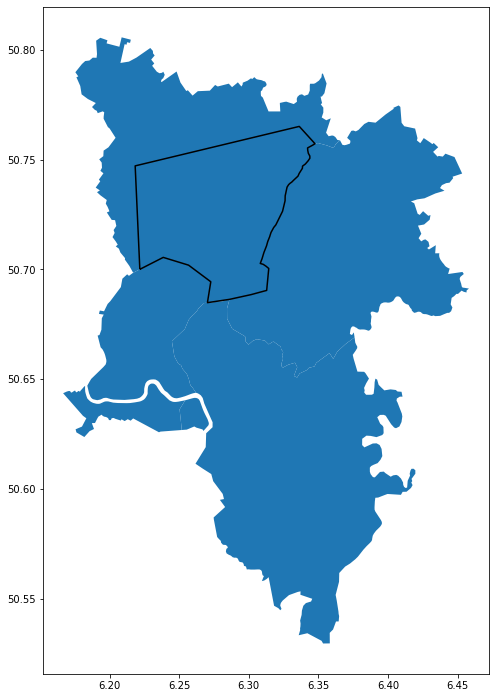

In [9]:
fig, ax = plt.subplots(figsize=(8, 15))

vg250.loc[vg250.AGS.isin(intersect_gdf.AGS)].plot(ax=ax)
mv_grid_gdf.boundary.plot(ax=ax, color="black")

plt.show()

As most municipalities only intersect the grid district at it's border only the electromobility data for one municipality needs to be generated

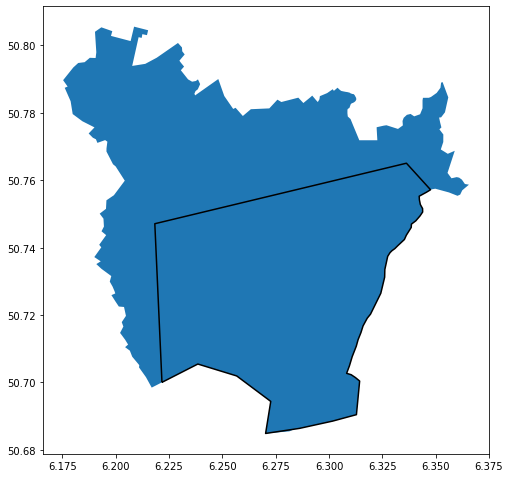

In [10]:
fig, ax = plt.subplots(figsize=(8, 15))

vg250.loc[vg250.AGS == "05334032"].plot(ax=ax)
mv_grid_gdf.boundary.plot(ax=ax, color="black")

plt.show()

## eDisGo add electromobility <a class="anchor" id="emob"></a>

### Electromobility data
So far, adding electormobility data to an eDisGo object requires electromobility data from SimBEV (required version: 3083c5a) and TracBEV (required version: 14d864c) to be stored in the directories specified through the parameters simbev_directory and tracbev_directory. SimBEV provides data on standing times, charging demand, etc. per vehicle, whereas TracBEV provides potential charging point locations.

If you don't have simBEV and tracBEV data yet, you can execute the following to use precalculated example data for the ding0 grid downloaded above.

In order to import the electromobility data of the grid that you downloaded above and integrate charging points into grid, you can use the function `import_electromobility`.

### Allocation of charging demand

After electromobility data is loaded, the charging demand from SimBEV is allocated to potential charging parks from TracBEV. The allocation of the charging processes to the charging infrastructure is carried out with the help of the weighting factor of the potential charging parks determined by TracBEV. This involves a random and weighted selection of one charging park per charging process. In the case of private charging infrastructure, a separate charging point is set up for each EV. All charging processes of the respective EV and charging use case are assigned to this charging point.

For the public charging infrastructure, the allocation is made explicitly per charging process. For each charging process it is determined whether a suitable charging point is already available. For this purpose it is checked if the charging point is occupied by another EV in the corresponding period and whether it can provide the corresponding charging capacity. If no suitable charging point is available, a charging point is determined randomly and weighted in the same way as for private charging.

### Integration of charging parks

Afterwards, all potential charging parks with charging demand allocated to them are integrated into the grid. This is realised the following way:

* If power rating < 0.3 MVA, then the charging demand is integrated in LV grid; otherwise integration in MV grid
* Integration in LV grid:
    * Integration in LV grid which distribution station is closest to the considered charging point
    * For power ratings > 0.1 MVA the charging point is connected directly to the distribution station
    * For power ratings < 0.1 MVA the type of connection depends on the use case:
        - Use Case `home`: Charging point is connected to a random household load on the identified LV grid
        - Use Case `work`: Charging point is connected to a random commercial, industrial or agricultural consumer
        - Use Case `public`: Charging point is connected to a random consumer that does not represent a household load
* Integration in MV grid:: 
    * The charging station is connected to the nearest network node or cable
    * If a cable is selected, the line is cut at the point closest to the charging station and a new cable closure is added to which the charging station is connected
    * If the connection power of the charging point is > 4.5 MVA, the charging station is connected directly to the HV-MV substation

In [11]:
edisgo.import_electromobility(
    simbev_directory=data_dir / "simbev_example_scenario_2",
    tracbev_directory=data_dir / "tracbev_example_scenario_2",
)

INFO:fiona.ogrext:Failed to auto identify EPSG: 7
INFO:edisgo:Duplicating potential charging parks to meet the desired grid connections to cars rate of 0.50 %. Iteration: 1.
INFO:edisgo:Duplicating potential charging parks to meet the desired grid connections to cars rate of 25.00 %. Iteration: 1.
/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:112: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:112: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:112: ShapelyDeprecationWarning:


### eDisGo electromobility data structure <a class="anchor" id="network"></a>

The EDisGo class serves as the top-level API and provides access to all relevant data. The electromobility sub-class holds all data coming from [SimBEV](https://github.com/rl-institut/simbev) and [TracBEV](https://github.com/rl-institut/tracbev).

```python
edisgo.electromobility
```

The electromobility data in the Topology object is stored in a pandas DataFrame and can be accessed as follows:

In [12]:
# SimBEV data
edisgo.electromobility.charging_processes_df.head()

,ags,car_id,destination,use_case,nominal_charging_capacity_kW,grid_charging_capacity_kW,chargingdemand_kWh,park_time_timesteps,park_start_timesteps,park_end_timesteps,charging_park_id,charging_point_id
0,5334032,1,0_work,work,50.0,55.5556,14.4159,15,218,232,1625,0
1,5334032,1,0_work,work,50.0,55.5556,14.5552,34,319,352,1625,0
2,5334032,1,3_shopping,public,50.0,55.5556,37.5000,3,626,628,1250,144
3,5334032,2,6_home,home,11.0,12.2222,10.3757,88,0,88,947,66
4,5334032,2,6_home,home,11.0,12.2222,10.7987,49,257,305,947,66


In [13]:
# SimBEV config
edisgo.electromobility.simbev_config_df

,eta_cp,stepsize,start_date,end_date,soc_min,grid_timeseries,grid_timeseries_by_usecase,days
0,0.9,15,2011-01-01,2011-01-07,0.2,True,True,7


In [14]:
# TracBEV data
edisgo.electromobility.potential_charging_parks_gdf.head()

,user_centric_weight,geometry,ags,use_case
0,1.000000,POINT (6.20975 50.78775),5334032,home
1,0.823529,POINT (6.20823 50.77150),5334032,home
2,0.705882,POINT (6.23117 50.76865),5334032,home
3,0.705882,POINT (6.23266 50.76780),5334032,home
4,0.694118,POINT (6.21535 50.75373),5334032,home


In [15]:
# Charging parks that got integrated
edisgo.electromobility.integrated_charging_parks_df.head()

,edisgo_id
88,Charging_Point_LVGrid_170186_home_1
358,Charging_Point_LVGrid_131067_home_1
566,Charging_Point_LVGrid_179719_home_1
620,Charging_Point_LVGrid_136382_home_1
737,Charging_Point_LVGrid_170180_home_1


In [16]:
edisgo.topology.charging_points_df.head()

,bus,p_set,type,annual_consumption,sector,voltage_level,p,mvlv_subst_id,geom
Charging_Point_LVGrid_170186_home_1,Bus_mvgd_2095_lvgd_170186_loa_102,0.0122,charging_point,NaN,home,7,0.0122,170186.0,POINT (6.276213849062917 50.75571589877431)
Charging_Point_LVGrid_131067_home_1,Bus_mvgd_2095_lvgd_131067_loa_106,0.0041,charging_point,NaN,home,7,0.0041,131067.0,POINT (6.221481863057472 50.73053634978644)
Charging_Point_LVGrid_179719_home_1,Bus_mvgd_2095_lvgd_179719_loa_18,0.0122,charging_point,NaN,home,7,0.0122,179719.0,POINT (6.328096635017962 50.763678995461746)
Charging_Point_LVGrid_136382_home_1,Bus_mvgd_2095_lvgd_136382_loa_12,0.0122,charging_point,NaN,home,7,0.0122,136382.0,POINT (6.2577134043525735 50.7209191089763)
Charging_Point_LVGrid_170180_home_1,Bus_mvgd_2095_lvgd_170180_loa_22,0.0041,charging_point,NaN,home,7,0.0041,170180.0,POINT (6.266109373898613 50.74009021249352)


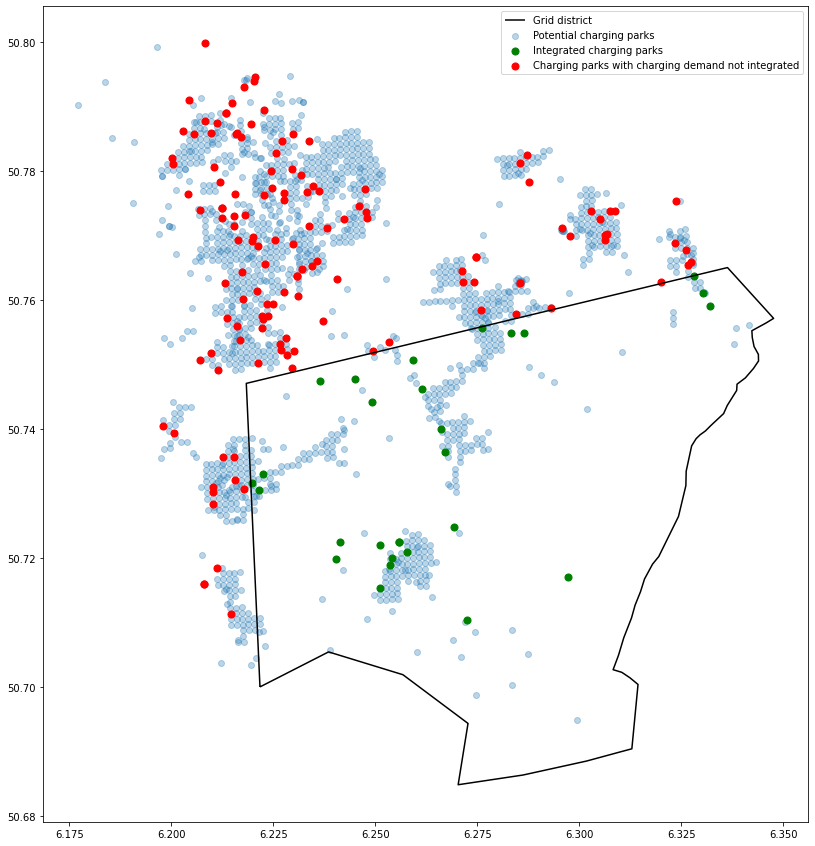

In [17]:
# plotting the grid district and all potential charging parks
fig, ax = plt.subplots(figsize=(15, 15))

mv_grid_gdf.boundary.plot(ax=ax, color="black")

# plot potential charging parks
edisgo.electromobility.potential_charging_parks_gdf.plot(ax=ax, alpha=0.3)

# plot integrated charging parks
edisgo.electromobility.potential_charging_parks_gdf.loc[
    edisgo.electromobility.integrated_charging_parks_df.index
].plot(ax=ax, color="green", markersize=50)

# plot charging parks with charging demand but outside of the grid district
# and therefore not integrated
charging_parks_with_charging_demand = (
    edisgo.electromobility.charging_processes_df.charging_park_id.unique()
)
charging_parks_not_integrated = set(charging_parks_with_charging_demand) - set(
    edisgo.electromobility.integrated_charging_parks_df.index
)

edisgo.electromobility.potential_charging_parks_gdf.loc[
    charging_parks_not_integrated
].plot(ax=ax, color="red", markersize=50)

ax.legend(
    [
        "Grid district",
        "Potential charging parks",
        "Integrated charging parks",
        "Charging parks with charging demand not integrated",
    ]
)

plt.show()

In [18]:
edisgo.topology.charging_points_df.head()

,bus,p_set,type,annual_consumption,sector,voltage_level,p,mvlv_subst_id,geom
Charging_Point_LVGrid_170186_home_1,Bus_mvgd_2095_lvgd_170186_loa_102,0.0122,charging_point,NaN,home,7,0.0122,170186.0,POINT (6.276213849062917 50.75571589877431)
Charging_Point_LVGrid_131067_home_1,Bus_mvgd_2095_lvgd_131067_loa_106,0.0041,charging_point,NaN,home,7,0.0041,131067.0,POINT (6.221481863057472 50.73053634978644)
Charging_Point_LVGrid_179719_home_1,Bus_mvgd_2095_lvgd_179719_loa_18,0.0122,charging_point,NaN,home,7,0.0122,179719.0,POINT (6.328096635017962 50.763678995461746)
Charging_Point_LVGrid_136382_home_1,Bus_mvgd_2095_lvgd_136382_loa_12,0.0122,charging_point,NaN,home,7,0.0122,136382.0,POINT (6.2577134043525735 50.7209191089763)
Charging_Point_LVGrid_170180_home_1,Bus_mvgd_2095_lvgd_170180_loa_22,0.0041,charging_point,NaN,home,7,0.0041,170180.0,POINT (6.266109373898613 50.74009021249352)


Be aware that the import_electromobility() function does not yield charging time series per charging point but only charging processes. The actual charging time series are determined through applying a charging strategy using the function charging_strategy.

The charging processes can be accessed through the edisgo.network.electromobility module as follows:

In [19]:
edisgo.electromobility.charging_processes_df.head()

,ags,car_id,destination,use_case,nominal_charging_capacity_kW,grid_charging_capacity_kW,chargingdemand_kWh,park_time_timesteps,park_start_timesteps,park_end_timesteps,charging_park_id,charging_point_id
0,5334032,1,0_work,work,50.0,55.5556,14.4159,15,218,232,1625,0
1,5334032,1,0_work,work,50.0,55.5556,14.5552,34,319,352,1625,0
2,5334032,1,3_shopping,public,50.0,55.5556,37.5000,3,626,628,1250,144
3,5334032,2,6_home,home,11.0,12.2222,10.3757,88,0,88,947,66
4,5334032,2,6_home,home,11.0,12.2222,10.7987,49,257,305,947,66


In order to obtain charging time series, a charging strategy to set EV charging time series at charging parks has to be applied. The aim of the charging strategies is to generate the most grid-friendly charging behavior possible without restricting the convenience for end users. Therefore, the boundary condition of all charging strategies is that the charging requirement of each charging process must be fully covered. This means that charging processes can only be used as a flexibility if the EV can be fully charged while it is stationary. Furthermore, only private charging processes can be used as a flexibility, since the fulfillment of the service is the priority for public charging processes. In order to be able to evaluate the three charging strategies, a reference charging strategy is also examined.
The eDisGo tool offers three different charging strategies: `dumb`, `reduced` and `residual`.

* `dumb`: is the default charging strategy and corresponds to the reference charging. The cars are charged directly after arrival with the maximum possible charging capacity. 

* `reduced`: preventive charging strategy. The cars are charged directly after arrival with the minimum possible charging power. The minimum possible charging power is determined by the parking time and the parameter minimum_charging_capacity_factor.

* `residual`: active charging strategy. The cars are charged when the residual load in the MV grid is lowest (high generation and low consumption). Charging processes with a low flexibility are given priority.

To keep the calculation time low only worst-case timesteps are calculated

In [20]:
residual_load = edisgo.timeseries.residual_load

worst_case_time_steps = pd.DatetimeIndex(
    [residual_load.idxmin(), residual_load.idxmax()]
)

# copy edisgo object
edisgo2 = deepcopy(edisgo)
edisgo3 = deepcopy(edisgo)

In [21]:
edisgo.apply_charging_strategy(strategy="dumb")
edisgo.analyze(timesteps=worst_case_time_steps)

INFO:root:Charging strategy dumb completed.
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2011-01-01 04:00:00', '2011-01-03 18:00:00'], dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.094926 seconds
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.124741 seconds


DatetimeIndex([], dtype='datetime64[ns]', name='snapshot', freq=None)

To change the charging strategy from the default `dumb` to one of the other strategies, the `strategy` parameter has to be set accordingly:

In [22]:
edisgo2.apply_charging_strategy(strategy="reduced")
edisgo2.analyze(timesteps=worst_case_time_steps)

INFO:root:Charging strategy reduced completed.
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2011-01-01 04:00:00', '2011-01-03 18:00:00'], dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.090074 seconds
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.130514 seconds


DatetimeIndex([], dtype='datetime64[ns]', name='snapshot', freq=None)

In [23]:
edisgo3.apply_charging_strategy(strategy="residual")
edisgo3.analyze(timesteps=worst_case_time_steps)

INFO:root:Charging strategy residual completed.
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2011-01-01 04:00:00', '2011-01-03 18:00:00'], dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.089098 seconds
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.134454 seconds


DatetimeIndex([], dtype='datetime64[ns]', name='snapshot', freq=None)

#### Plot charging point time series and residual load depending on charging strategy

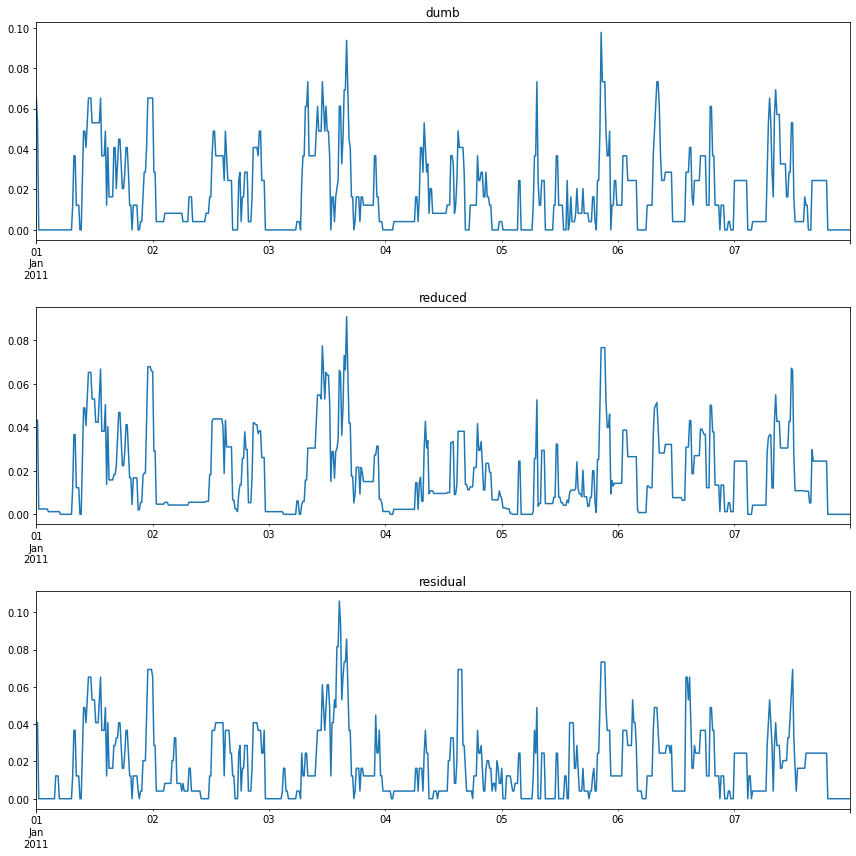

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

edisgo.timeseries.charging_points_active_power(edisgo).sum(axis=1).plot.line(
    ax=ax1, title="dumb"
)
edisgo2.timeseries.charging_points_active_power(edisgo2).sum(axis=1).plot.line(
    ax=ax2, title="reduced"
)
edisgo3.timeseries.charging_points_active_power(edisgo3).sum(axis=1).plot.line(
    ax=ax3, title="residual"
)

plt.tight_layout()

plt.show()

/home/kilian/Documents/PythonProjects/eDisGo_orig/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



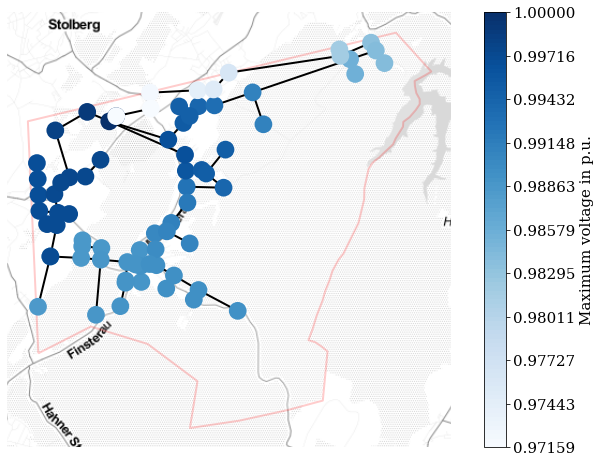

/home/kilian/Documents/PythonProjects/eDisGo_orig/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



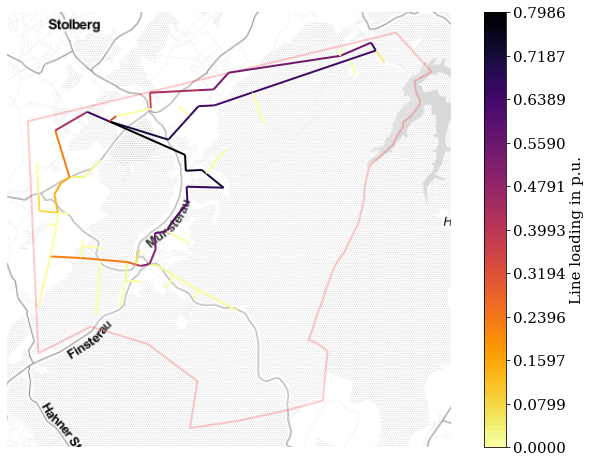

In [25]:
edisgo.plot_mv_voltages()
edisgo.plot_mv_line_loading()

/home/kilian/Documents/PythonProjects/eDisGo_orig/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



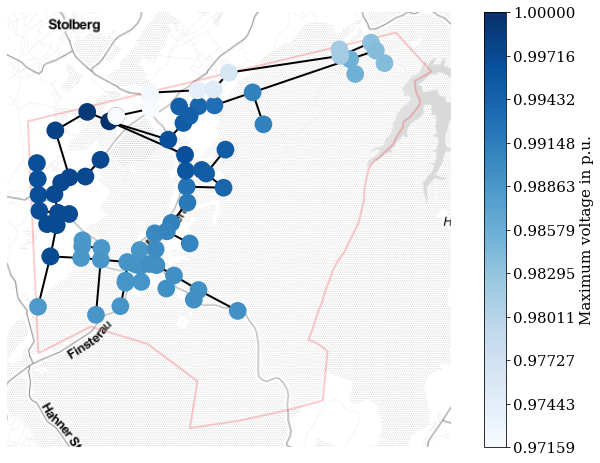

/home/kilian/Documents/PythonProjects/eDisGo_orig/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



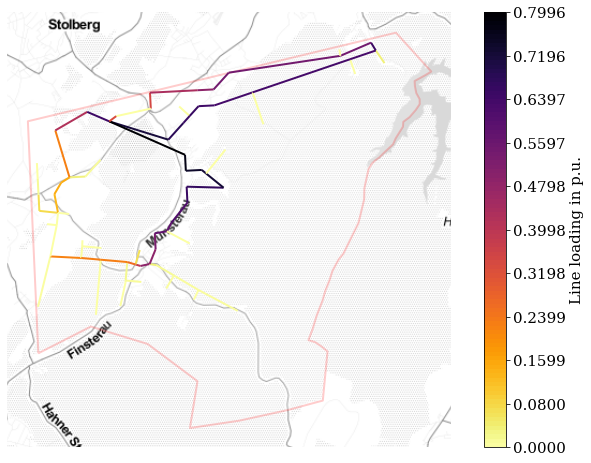

In [26]:
edisgo2.plot_mv_voltages()
edisgo2.plot_mv_line_loading()

/home/kilian/Documents/PythonProjects/eDisGo_orig/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



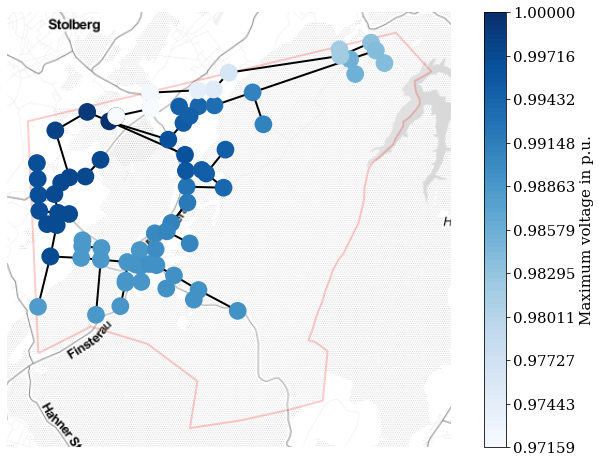

/home/kilian/Documents/PythonProjects/eDisGo_orig/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



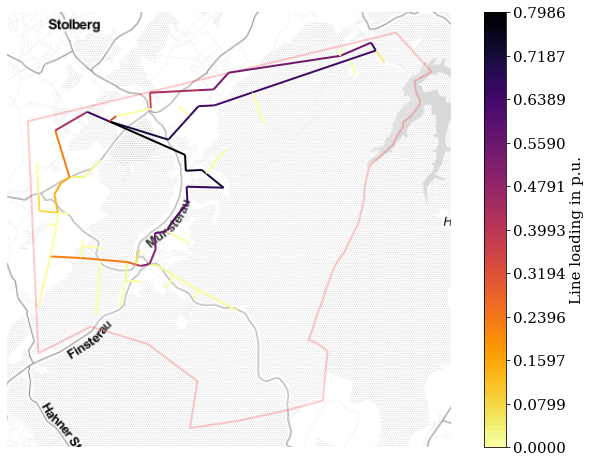

In [27]:
edisgo3.plot_mv_voltages()
edisgo3.plot_mv_line_loading()